# Real Estate Price Preditor

The model below predicts real estate prices based on the datasets provided in the Kaggle on-going competition "House Prices - Advanced Regression Techniques".  The original dataset contained 81 different features per row, however, this model considers primarily the features explicitly advertised on real estate apps (for example, total square footage, neighborhood/ subdivision, number of bathrooms and bedrooms).

In [150]:
import pandas as pd
import numpy as np

df = pd.read_csv('train.csv')
print(df.columns)

pd.set_option('mode.chained_assignment', None)


Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

### Quantifying Qualitative Data (Part I)

This data set included many continuous features, such as SalePrice and GarageArea, but it also included features that were categorical and ordinal.  Categorical data like Neighborhood and RoofStyle is identified by a group label, rather than a number.  Similarly, ordinal data are not number either, rather group labels that represent a progression or sequence.  For example, BsmtQual (Basement Quality) is a label given based on a spectrum of groupings (Poor, Fair, Typical/ Average, Good, and Excellent).  Machine learning models require quantitative inputs, thus the categorical and ordinal features had to be transformed into numbers.

Categorical features will be transformed into appropriate inputs for machine learning in Quantifying Qualitative Data (Part II).


In [151]:
func_dict = {
    'Typ':7,
    'Min1':6,
    'Min2':5,
    'Mod':4,
    'Maj1':3,
    'Maj2':2,
    'Sev':1,
    'Sal':0  
}

df['FuncScore'] = df['Functional'].map(lambda x: func_dict[x])

quality_dict = {
    'Ex':5,
    'Gd':4,
    'TA':3,
    'Fa':2,
    'Po':1, 
    'No':0
}


# Features ending in 'Score' have been converted from strings to ordered integers
df['KitchenQualScore'] = df['KitchenQual'].map(lambda x: quality_dict[x])

df.loc[df['BsmtQual'].isnull(),'BsmtQual'] = "No"
df['BsmtQualScore'] = df['BsmtQual'].map(lambda x: quality_dict[x])
df.loc[df['BsmtCond'].isnull(),'BsmtCond'] = "No"
df['BsmtCondScore'] = df['BsmtCond'].map(lambda x: quality_dict[x])
df.loc[df['ExterQual'].isnull(),'ExterQual'] = "No"
df['ExterQualScore'] = df['ExterQual'].map(lambda x: quality_dict[x])
df.loc[df['ExterCond'].isnull(),'ExterCond'] = "No"
df['ExterCondScore'] = df['ExterCond'].map(lambda x: quality_dict[x])

# Features with yes/ no categories were changed to 1 and 0 respectively
df['CentralAirScore'] = df['CentralAir'].map(lambda x: 1 if x.title().strip() == 'Y' else 0)


### Features Of Interest

The following model is based on the features below.

In [152]:
features_of_interest = [
    '1stFlrSF',
    '2ndFlrSF',
    'TotalBsmtSF',
    'OverallQual',
    'OverallCond',
    'FuncScore',
    'TotRmsAbvGrd',
    'BedroomAbvGr',
    'LotArea',
    'GarageArea',
    'KitchenQualScore',
    'BsmtQualScore',
    'BsmtCondScore',
    'CentralAirScore',
    'FullBath',
    'BsmtFullBath',
    'BsmtHalfBath',
    'HalfBath',
    'ExterQualScore',
    'ExterCondScore',
    'SalePrice',
    
    'RoofStyle', 
    'RoofMatl', 
    'Exterior1st', 
    'Exterior2nd', 
    'MasVnrType', 
    'Foundation', 
    'GarageType',
    'MiscFeature',
    'SaleType',
    'SaleCondition',
    'MSSubClass',
    'MSZoning',
    'Street',
    'Alley',
    'LandContour',
    'Neighborhood',
    'Condition1',
    'Condition2',
    'BldgType',
    'HouseStyle'
]

df_foi = df[features_of_interest]


### Checking For Missing Values

Missing values must be considered if they exist in a data set.  None exist in the data set to be used to split, train and test the machine learning model.


In [153]:
for feature in features_of_interest:
    print(f"Number of null values for {feature}:", df_foi.loc[df_foi[feature].isnull(), feature].count())
    

Number of null values for 1stFlrSF: 0
Number of null values for 2ndFlrSF: 0
Number of null values for TotalBsmtSF: 0
Number of null values for OverallQual: 0
Number of null values for OverallCond: 0
Number of null values for FuncScore: 0
Number of null values for TotRmsAbvGrd: 0
Number of null values for BedroomAbvGr: 0
Number of null values for LotArea: 0
Number of null values for GarageArea: 0
Number of null values for KitchenQualScore: 0
Number of null values for BsmtQualScore: 0
Number of null values for BsmtCondScore: 0
Number of null values for CentralAirScore: 0
Number of null values for FullBath: 0
Number of null values for BsmtFullBath: 0
Number of null values for BsmtHalfBath: 0
Number of null values for HalfBath: 0
Number of null values for ExterQualScore: 0
Number of null values for ExterCondScore: 0
Number of null values for SalePrice: 0
Number of null values for RoofStyle: 0
Number of null values for RoofMatl: 0
Number of null values for Exterior1st: 0
Number of null valu

### Quantifying Qualitative Data (Part II)

To convert the categorical features into input data that is appropriate for machine learning models, each label for each feature was given a distinct column.  If the home was a part of that category, it will recieve a value of 1 for that column and a 0 for the other categories for that particular feature.

In [154]:
category_features_to_dummies = [
    'RoofStyle', 
    'RoofMatl', 
    'Exterior1st', 
    'Exterior2nd', 
    'MasVnrType', 
    'Foundation', 
    'GarageType',
    'MiscFeature',
    'SaleType',
    'SaleCondition',
    'MSSubClass',
    'MSZoning',
    'Street',
    'Alley',
    'LandContour',
    'Neighborhood',
    'Condition1',
    'Condition2',
    'BldgType',
    'HouseStyle'
]

for feature in category_features_to_dummies:
    temp_df = pd.get_dummies(df_foi[feature], prefix=feature, prefix_sep='_')
    df_foi = df_foi.join(temp_df)
    df_foi.drop(columns=feature, inplace=True)
    

In [155]:
df_foi.columns

Index(['1stFlrSF', '2ndFlrSF', 'TotalBsmtSF', 'OverallQual', 'OverallCond',
       'FuncScore', 'TotRmsAbvGrd', 'BedroomAbvGr', 'LotArea', 'GarageArea',
       ...
       'BldgType_Twnhs', 'BldgType_TwnhsE', 'HouseStyle_1.5Fin',
       'HouseStyle_1.5Unf', 'HouseStyle_1Story', 'HouseStyle_2.5Fin',
       'HouseStyle_2.5Unf', 'HouseStyle_2Story', 'HouseStyle_SFoyer',
       'HouseStyle_SLvl'],
      dtype='object', length=184)

### Standardizing The Data

All the continuous and ordinal features will be standardized by computing the respective Z-scores.  Data should be standardized to prevent the features with greater variance across values from having more influence in machine learning model.

In [156]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

continuous_features = [
    '1stFlrSF',
    '2ndFlrSF',
    'TotalBsmtSF',
    'OverallQual',
    'OverallCond',
    'FuncScore',
    'TotRmsAbvGrd',
    'BedroomAbvGr',
    'LotArea',
    'GarageArea',
    'KitchenQualScore',
    'BsmtQualScore',
    'BsmtCondScore',
    'CentralAirScore',
    'FullBath',
    'BsmtFullBath',
    'BsmtHalfBath',
    'HalfBath',
    'ExterQualScore',
    'ExterCondScore'
]

scaler = preprocessing.StandardScaler()
for feature in continuous_features:
    df_foi[feature] = scaler.fit_transform(df_foi[feature].values.reshape(-1,1))


### Splitting Data Into Train And Test Sets

To avoid overfitting the model to the entire data set, the 'NeighborhoodAvgPrice' and 'NeighborhoodMedPrice' are computed after the data set has been split into train and test sets.  

In [157]:
from sklearn.model_selection import train_test_split


y = df['SalePrice']
X = df_foi


### Feature Exploration

Plotting the different features of interest (standardized) against the sale price suggests that there may be a quadratic relationship between these features and sale price.  Consequently, a Polynomial Linear Regression model was used for the first Machine Learning model.

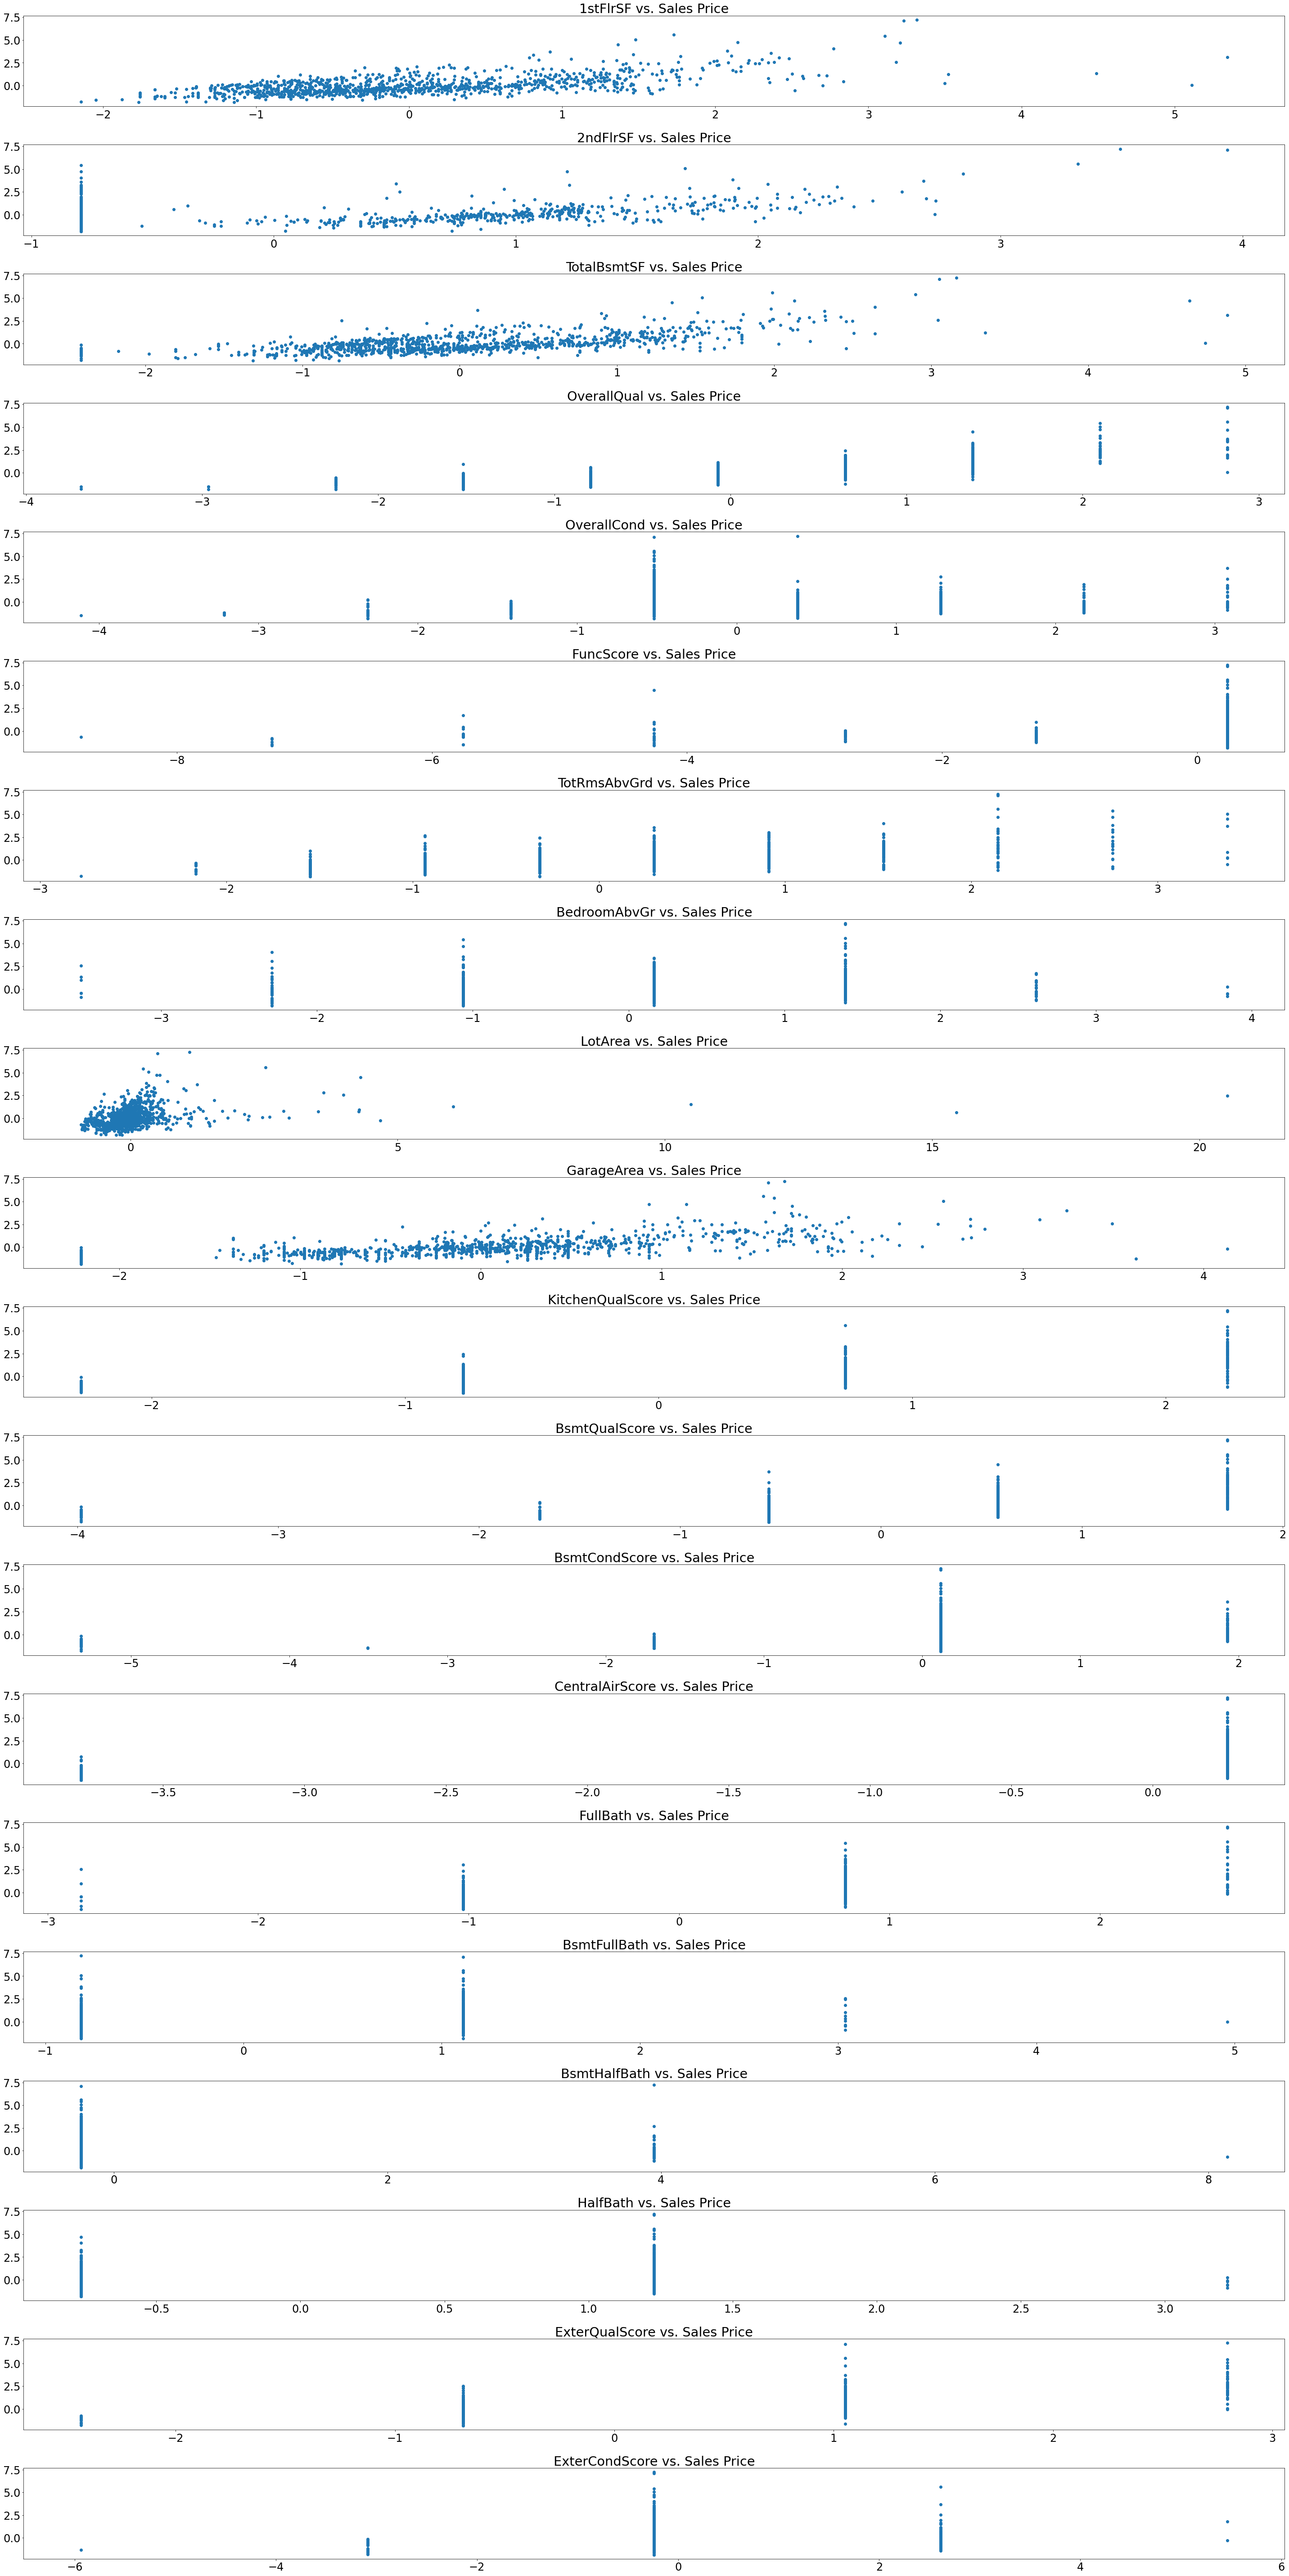

In [158]:
import matplotlib.pyplot as plt


fig, axs = plt.subplots(len(continuous_features), figsize=(40, 80))

for feature in continuous_features:
    axs[continuous_features.index(feature)].scatter(x=X_train[feature], y=y_train)
    axs[continuous_features.index(feature)].set_title("{} vs. Sales Price".format(feature, pad=40))

plt.rc('font', size=24)
fig.tight_layout()
plt.show()


### Training And Testing The Polynomial Linear Regression Model


In [159]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_train) 
model = LinearRegression()
model.fit(X_poly, y_train) 

X_test_poly = poly.transform(X_test)
y_test_predictions = model.predict(X_test_poly)
rmse = np.sqrt(mean_squared_error(y_test,y_test_predictions))
r2 = r2_score(y_test,y_test_predictions)
print('Test RMSE: ', rmse)
print('Test R2: ', r2)


Test RMSE:  0.039381576664262216
Test R2:  0.9980190979063583


### Conclusion

This model is very accurate.  The square root of the mean squared error (RMSE) measures how well a model is capable of integrating a data set.  The smaller the RMSE, the closer the model predicts accurately.  The R-squared score represents the proportion of the variance for a dependent variable that's explained by the independent variables in a regression model.  The higher the score, the better the model.
